# Imports and functions

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
citiesnp = np.genfromtxt('cities.csv', delimiter=',', skip_header = 1) # load as numpy array

In [3]:
def not_prime(n):
    if n == 2:
        return False
    if n % 2 == 0 or n <= 1:
        return True

    sqr = int(math.sqrt(n)) + 1

    for divisor in range(3, sqr, 2):
        if n % divisor == 0:
            return True
    return False

In [4]:
np_not_prime = np.vectorize(not_prime)

In [5]:
def np_total_length(r, c):
    r = np.concatenate(([0], r))
    c = c[r, :]
    cs = np.roll(c, -1, axis =0)
    d = np.sqrt((c[:,1] - cs[:,1])**2 + (c[:,2] - cs[:,2])**2)
    m = np.concatenate((np.arange(1, len(c)+1)[np.newaxis,:],
                        cs[:, 0][np.newaxis,:],
                        d[np.newaxis,:]))
    p = m[:, np.arange(9, len(c), 10)]
    sel = p[0,][np_not_prime(p[1,])].astype(int)
    m[:, sel-1] *= 1.1
    
    return np.sum(m[2])

In [6]:
def route_fitness(r, c):
    return 1 / np_total_length(r, c)

In [7]:
np.random.seed(4)
idx = np.random.permutation(range(1, len(citiesnp)))

In [8]:
np_total_length(idx, citiesnp)

446925531.9322754

In [9]:
cities_sub = citiesnp[0:26]

In [10]:
np.random.seed(3)
idx = np.random.permutation(range(1,26))

In [11]:
np_total_length(idx, cities_sub)

60566.12398696876

# Genetic algorithm

### Generate Population

In [12]:
def pop_gen(n, pop_size):
    arr = np.repeat([np.arange(1, n)], pop_size, 0)
    return np.apply_along_axis(np.random.permutation, 1, arr)    

### Evaluate population

In [13]:
def pop_eval(array, pop, fit_fun):
    return np.apply_along_axis(fit_fun, 1, pop, c = array)

In [14]:
def pop_stats(scores):
    mean = np.mean(scores)
    med = np.median(scores)
    best = np.max(scores)
    return med, mean, best

### Selection

In [15]:
def roulette_selection(pop, scores, size):
    if size % 2 != 0:
        size += 1
    p = scores/np.sum(scores)
    sel = np.random.choice(len(pop), size, replace = True, p = p).reshape((size//2, 2))    
    return np.concatenate((pop[sel][:,0], pop[sel][:,1]), 1)

### Crossover

In [16]:
def pairwise_crossover(p):
    n = len(p) // 2
    p0 = p[:n]
   
    p1 = p[n:]
    swath = np.random.randint(1, n)
    
    cut1 = np.random.randint(0, n - swath)
    cut2 = cut1 + swath
    
    off = np.repeat([0], n)
    
    sel = p0[cut1:cut2]
    off[cut1:cut2] = sel
    sel = p1[~np.isin(p1, sel)]
    off[0:cut1] = sel[0:cut1]

    off[cut2:] = sel[cut1:]
    return off   

In [17]:
def crossover(pa):
    return np.apply_along_axis(pairwise_crossover, 1, pa)

### Mutation

In [18]:
def swap_mutation(perm):
    n = len(perm)
    i = np.random.choice(n, 2, replace = False)
    perm[i] = perm[i[::-1]]
    return perm

In [19]:
def reverse_mutation(perm):
    n = len(perm) - 1
    i = np.random.choice(n, 1)[0]
    perm[i:i+2] = perm[i:i+2][::-1]
    return(perm)

In [20]:
def pop_mutation(pop, mut_fun, mut_perc):
    sel = np.random.choice(len(pop), int(len(pop) * mut_perc), replace = False)
    pop[sel] = np.apply_along_axis(mut_fun, 1, pop[sel])
    return pop

### GA

In [21]:
def GA(array, n_gen, pop_size, parent_size, fit_fun, mut_fun, mut_perc, verbose = False):
    n = len(array)
    
    # init pop
    pop = pop_gen(n, pop_size)
    
    scores = pop_eval(array, pop, fit_fun)
    
    med, mean, best = pop_stats(scores)
    med_trace = np.array([med])
    mean_trace = np.array([mean])
    best_trace = np.array([best])
    
    for i in range(1, n_gen):
        
        # select best parents
        parents = roulette_selection(pop, scores, parent_size)
        
        # generate offsprings
        offs = crossover(parents)
        
        # replace worst in pop with offs
        sort = np.argsort(scores)
        pop[sort[:len(offs)]] = offs
        
        # mutate pop
        pop = pop_mutation(pop, mut_fun, mut_perc)
        
        # evaluate
        scores = pop_eval(array, pop, fit_fun)
        
        # update traces
        med, mean, best = pop_stats(scores)
        med_trace = np.concatenate((med_trace, [med]))
        mean_trace = np.concatenate((mean_trace, [mean]))
        best_trace =  np.concatenate((best_trace, [best]))
        
        if verbose:
            if i % 10 == 0:
                print('Iter {}, Best {}'.format(i, 1/best))
        
    return med_trace, mean_trace, best_trace, pop

In [22]:
def plot_GA(a, b, c, n):
    fig, ax = plt.subplots(figsize=(10,6))

    x = np.arange(0, len(c), n)
    l1 = ax.plot(x, a[::n])[0]
    l2 = ax.plot(x, b[::n])[0]
    l3 = ax.plot(x, c[::n])[0]
    
    line_labels = ["Median", "Average", "Best"]
    
    fig.legend([l1, l2, l3], line_labels, bbox_to_anchor=(0.85, 0.25))
    
    plt.show()

### Testing

In [23]:
np.random.seed(4)
a1, b1, c1, d1 = GA(cities_sub, 1000, 20, 20, route_fitness, reverse_mutation, 0.3)

In [24]:
1/c1[-1] #tour length of best route

38039.41247483975

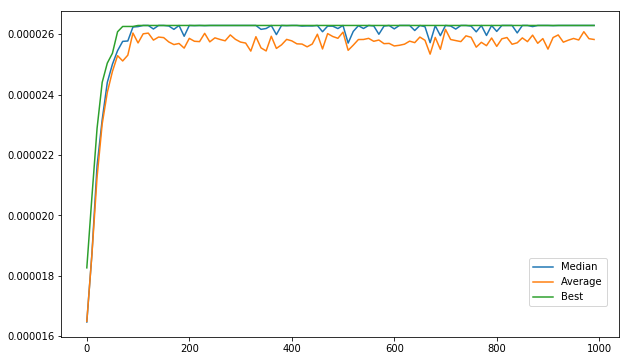

In [25]:
plot_GA(a1, b1, c1, 10)

In [26]:
np.random.seed(4)
a2, b2, c2, d2 = GA(citiesnp, 500, 10, 6, route_fitness, reverse_mutation, 0.1, verbose = True)

Iter 10, Best 446080480.8298834
Iter 20, Best 445834768.3962786
Iter 30, Best 445814083.13944304
Iter 40, Best 445653517.98205185
Iter 50, Best 445613013.15113306
Iter 60, Best 445599368.7319229
Iter 70, Best 445596994.759071
Iter 80, Best 445596406.6891028
Iter 90, Best 445591005.5518391
Iter 100, Best 445582430.3247225
Iter 110, Best 445569495.29349095
Iter 120, Best 445565198.4621139
Iter 130, Best 445562780.33022195
Iter 140, Best 445559059.94742703
Iter 150, Best 445556888.0584714
Iter 160, Best 445554302.96297324
Iter 170, Best 445553386.78791237
Iter 180, Best 445552260.7361889
Iter 190, Best 445550473.3692474
Iter 200, Best 445547388.52909416
Iter 210, Best 445542449.37605643
Iter 220, Best 445540531.9407921
Iter 230, Best 445537144.3247161
Iter 240, Best 445537144.3247161
Iter 250, Best 445536177.99205923
Iter 260, Best 445532250.2595727
Iter 270, Best 445528872.55714214
Iter 280, Best 445528872.55714214
Iter 290, Best 445524940.3734164
Iter 300, Best 445522137.50934875
Iter 3

In [27]:
1/c2[-1] #tour length of best route

445439629.0342254

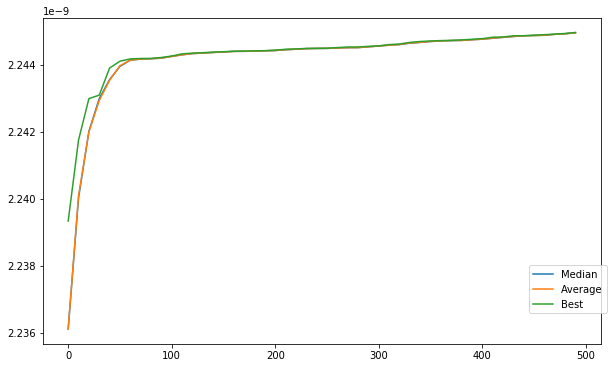

In [28]:
plot_GA(a2, b2, c2, 10)